In [ ]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.0 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import glob

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/AI2-Project')

cwd = os.getcwd()
print(cwd)

Mounted at /content/drive
/content/drive/My Drive/AI2-Project


In [ ]:
images_dir = '/content/drive/My Drive/AI2-Project/CUB_200_2011/images'

In [ ]:
import pathlib
images_dir = pathlib.Path(images_dir)

image_count = len(list(images_dir.glob('*/*.jpg')))
print(image_count)

11788


In [ ]:
list_ds = tf.data.Dataset.list_files(str(images_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [ ]:
class_names = np.array(sorted([item.name for item in images_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names.shape)

(200,)


In [ ]:
val_size = int(4716)
train_ds = list_ds.take(val_size)
val_ds = list_ds.skip(val_size)
val_ds = list_ds.take(1178)

In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

4716
1178


In [ ]:
img_height = 256
img_width = 256

def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.one_hot(tf.argmax(one_hot),200)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)/255
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label


In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
  print(image.numpy().max(), image.numpy().min())

Image shape:  (256, 256, 3)
Label:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
1.0 0.0


In [ ]:
batch_size = 32

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

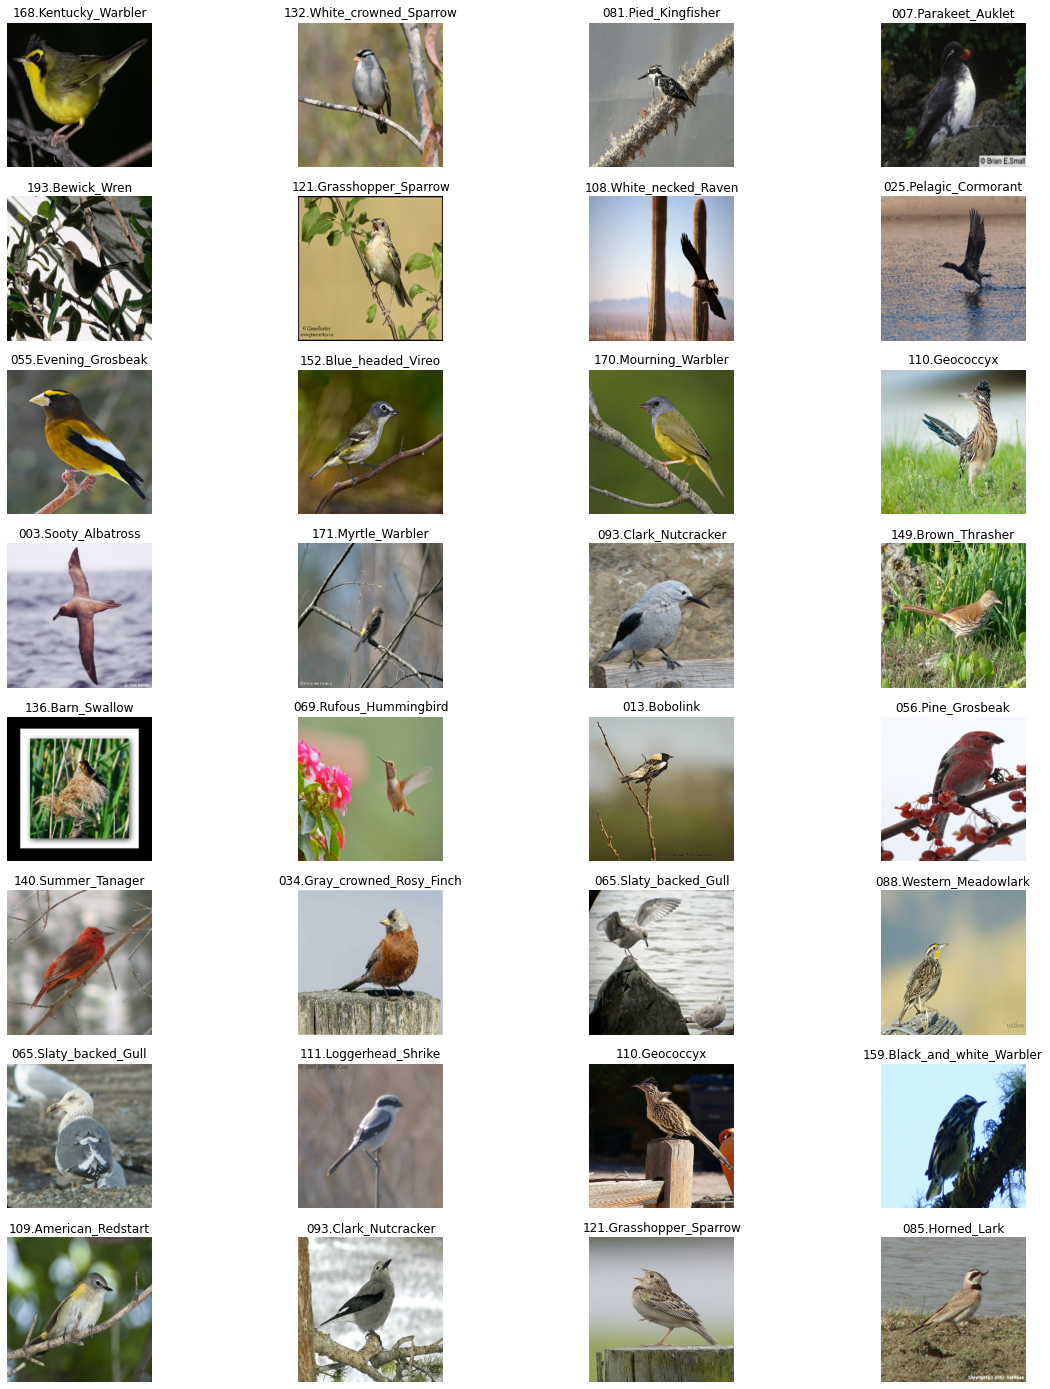

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(20, 25))
for i in range(32):
  ax = plt.subplot(8, 4, i + 1)
  plt.imshow(image_batch[i].numpy())
  label = tf.argmax(label_batch[i])
  plt.title(class_names[label])
  plt.axis("off")

In [ ]:
model_A =  tf.keras.applications.MobileNetV2(input_shape=(256,256,3), weights='imagenet', include_top=False)
model_A.trainable = False
model_A.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                

In [ ]:
prediction_layer = tf.keras.layers.Dense(200, activation='softmax')
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
spatial_dropout = tf.keras.layers.SpatialDropout2D(0.2, data_format='channels_last')

for layer in model_A.layers[:10]:
  layer.trainable =  False

for layer in model_A.layers[10:]:
  layer.trainable = True

In [ ]:
model_B = tf.keras.Sequential([
  #tf.keras.layers.Rescaling(1./255),
  model_A,
  spatial_dropout,
  global_average_layer,
  prediction_layer
])

In [ ]:
model_B.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

epochs=15
history = model_B.fit(train_ds, validation_data=val_ds,epochs=epochs)

Epoch 1/15
148/148 [==============================] - 1234s 8s/step - loss: 4.8007 - accuracy: 0.0755 - val_loss: 3.7584 - val_accuracy: 0.2267
Epoch 2/15
148/148 [==============================] - 14s 95ms/step - loss: 3.0652 - accuracy: 0.3545 - val_loss: 2.7310 - val_accuracy: 0.4109
Epoch 3/15
148/148 [==============================] - 15s 99ms/step - loss: 2.1834 - accuracy: 0.5403 - val_loss: 2.1145 - val_accuracy: 0.5297
Epoch 4/15
148/148 [==============================] - 14s 95ms/step - loss: 1.6491 - accuracy: 0.6643 - val_loss: 1.6617 - val_accuracy: 0.6460
Epoch 5/15
148/148 [==============================] - 14s 96ms/step - loss: 1.3367 - accuracy: 0.7294 - val_loss: 1.3663 - val_accuracy: 0.6927
Epoch 6/15
148/148 [==============================] - 14s 96ms/step - loss: 1.1063 - accuracy: 0.7844 - val_loss: 1.0957 - val_accuracy: 0.7861
Epoch 7/15
148/148 [==============================] - 14s 95ms/step - loss: 0.9430 - accuracy: 0.8297 - val_loss: 0.8777 - val_accuracy:

In [ ]:
#model_B.save('pretrained_model.h5')

pretrained_model = tf.keras.models.load_model('pretrained_model.h5')

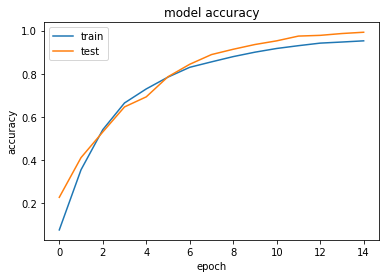

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

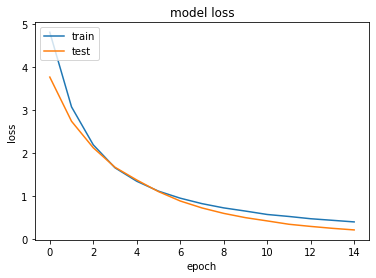

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 37ms/step
tf.Tensor(53, shape=(), dtype=int64)
054.Blue_Grosbeak


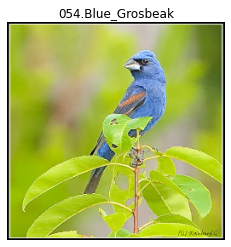

In [ ]:
image_batch, label_batch = next(iter(val_ds))

for image, label in val_ds.take(1):
  im_test = image[1].numpy()
  plt.imshow(im_test)
  label = tf.argmax(label[1])
  plt.title(class_names[label])
  plt.axis('off')


#for i in range(32):
#  ax = plt.subplot(8, 4, i + 1)
#  plt.imshow(image_batch[i].numpy())
#  label = tf.argmax(label_batch[i])
#  plt.title(class_names[label])
#  plt.axis("off")
prediction = model_B.predict(image)
print(tf.argmax(prediction[1]))
print(class_names[tf.argmax(prediction[1])])

## Vision Transformer

In [ ]:
class PatchExtractor(tf.keras.layers.Layer):

  def __init__(self):
    super(PatchExtractor, self).__init__()

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, 16, 16, 1],
        strides=[1, 16, 16, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

Image shape:  (256, 256, 3)


TensorShape([1, 256, 768])

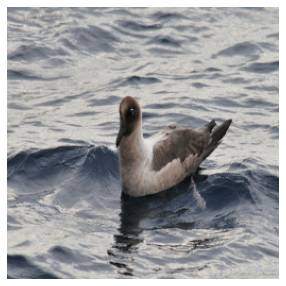

In [ ]:
for image, label in train_ds.take(1):
  print("Image shape: ", image[1].numpy().shape)
  plt.figure(figsize=(5, 5))
  plt.imshow(image[1].numpy())
  plt.axis("off");

batch = tf.expand_dims(image[1], axis=0)
patches = PatchExtractor()(batch)
patches.shape

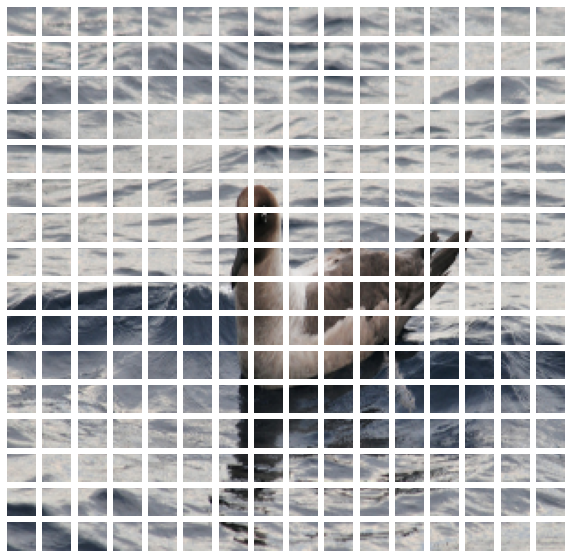

In [ ]:
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(10, 10))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (16, 16, 3))
    ax.imshow(patch_img.numpy())
    ax.axis("off")

In [ ]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches=256, projection_dim=768):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        w_init = tf.random_normal_initializer()
        class_token = w_init(shape=(1, projection_dim), dtype="float32")
        self.class_token = tf.Variable(initial_value=class_token, trainable=True)
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(input_dim=num_patches+1, output_dim=projection_dim)

    def call(self, patch):
        batch = tf.shape(patch)[0]
        # reshape the class token embedins
        class_token = tf.tile(self.class_token, multiples = [batch, 1])
        class_token = tf.reshape(class_token, (batch, 1, self.projection_dim))
        # calculate patches embeddings
        patches_embed = self.projection(patch)
        patches_embed = tf.concat([patches_embed, class_token], 1)
        # calcualte positional embeddings
        positions = tf.range(start=0, limit=self.num_patches+1, delta=1)
        positions_embed = self.position_embedding(positions)
        # add both embeddings
        encoded = patches_embed + positions_embed
        return encoded

In [ ]:
embeddings = PatchEncoder()(patches)
embeddings.shape

TensorShape([1, 257, 768])

In [ ]:
class MLP(tf.keras.layers.Layer):
  def __init__(self, hidden_features, out_features, dropout_rate=0.1):
    super(MLP, self).__init__()
    self.dense1 = tf.keras.layers.Dense(hidden_features, activation=tf.nn.gelu)
    self.dense2 = tf.keras.layers.Dense(out_features)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    x = self.dense1(x)
    x = self.dropout(x)
    x = self.dense2(x)
    y = self.dropout(x)
    return y

In [ ]:
mlp = MLP(768 * 2, 768)
y = mlp(tf.zeros((1, 257, 768)))
y.shape

TensorShape([1, 257, 768])

In [ ]:
class Block(tf.keras.layers.Layer):
  def __init__(self, projection_dim, num_heads=4, dropout_rate=0.1):
      super(Block, self).__init__()
      self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.attn = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate)
      self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.mlp = MLP(projection_dim * 2, projection_dim, dropout_rate)

  def call(self, x):
      x1 = self.norm1(x) # encoded_patches
      attention_output = self.attn(x1, x1) # multi-head attention layer.
      x2 = tf.keras.layers.Add()([attention_output, x]) #encoded_patches
      x3 = self.norm2(x2)
      x3 = self.mlp(x3)
      y = tf.keras.layers.Add()([x3, x2])
      return y

In [ ]:
block = Block(768)
y = block(tf.zeros((1, 257, 768)))
y.shape

TensorShape([1, 257, 768])

In [ ]:
class TransformerEncoder(tf.keras.layers.Layer):
  def __init__(self, projection_dim, num_heads=4, num_blocks=3, dropout_rate=0.1):
      super(TransformerEncoder, self).__init__()
      self.blocks = [Block(projection_dim, num_heads, dropout_rate) for _ in range(num_blocks)]
      self.norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.dropout = tf.keras.layers.Dropout(0.5)

  def call(self, x):
      # Create a [batch_size, projection_dim] tensor.
      for block in self.blocks:
          x = block(x)
      x = self.norm(x)
      y = self.dropout(x)
      return y

transformer = TransformerEncoder(768)
y = transformer(embeddings)
y.shape

TensorShape([1, 257, 768])

In [ ]:
def create_VisionTransformer(num_classes=200, num_patches=256, projection_dim=768, input_shape=(256, 256, 3)):
    inputs = tf.keras.layers.Input(shape=input_shape)
    # Patch extractor
    patches = PatchExtractor()(inputs)
    # Patch encoder
    patches_embed = PatchEncoder(num_patches, projection_dim)(patches)
    # Transformer encoder
    representation = TransformerEncoder(projection_dim)(patches_embed)
    representation = tf.keras.layers.GlobalAveragePooling1D()(representation)
    
    logits = MLP(projection_dim, num_classes, 0.5)(representation)
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
model = create_VisionTransformer()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 patch_extractor_1 (PatchExt  (None, None, 768)        0         
 ractor)                                                         
                                                                 
 patch_encoder_1 (PatchEncod  (None, 257, 768)         788736    
 er)                                                             
                                                                 
 transformer_encoder_1 (Tran  (None, 257, 768)         35437056  
 sformerEncoder)                                                 
                                                                 
 global_average_pooling1d (G  (None, 768)              0         
 lobalAveragePooling1D)                                      

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy")])

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
148/148 [==============================] - 114s 681ms/step - loss: 12.4592 - accuracy: 0.0053 - val_loss: 8.3907 - val_accuracy: 0.0051
Epoch 2/10
148/148 [==============================] - 104s 700ms/step - loss: 12.4020 - accuracy: 0.0053 - val_loss: 8.3213 - val_accuracy: 0.0051
Epoch 3/10
148/148 [==============================] - 104s 702ms/step - loss: 12.1267 - accuracy: 0.0040 - val_loss: 8.2785 - val_accuracy: 0.0051
Epoch 4/10
148/148 [==============================] - 103s 695ms/step - loss: 12.4007 - accuracy: 0.0057 - val_loss: 8.1855 - val_accuracy: 0.0051
Epoch 5/10
148/148 [==============================] - 102s 690ms/step - loss: 12.4257 - accuracy: 0.0055 - val_loss: 8.1054 - val_accuracy: 0.0051
Epoch 6/10
148/148 [==============================] - 104s 705ms/step - loss: 12.2264 - accuracy: 0.0074 - val_loss: 8.0791 - val_accuracy: 0.0051
Epoch 7/10
148/148 [==============================] - 103s 693ms/step - loss: 12.3511 - accuracy: 0.0053 - val_loss: 8

In [ ]:
model.save('VisionTransformer.h5')

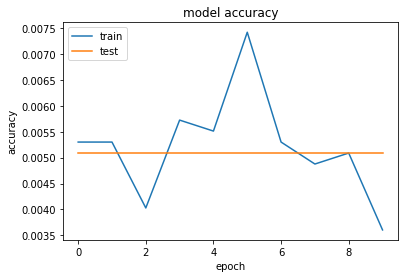

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

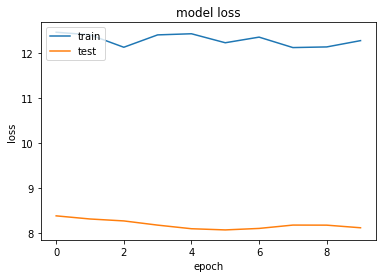

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()